In [15]:
import numpy as np
import pandas as pd
import seaborn as sb
sb.set()
from datetime import datetime, timedelta
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,6
import math
import scipy.stats
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

In [16]:
def dowload_data():
    
    # Stocks prices
    df = pd.read_csv('../DATA/PrepData.csv', date_parser=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Choesen wallet
    weights = pd.read_csv('../DATA/choesenWallet.csv', index_col=False).drop('Unnamed: 0', axis=1).values[0]
    weights = np.round(weights,4)
    
    return weights, df
    
def prepare_data(investmentAmt, df, weights):
    
    # How many stock
    assetsQuant = len(df.columns)
    
    # Equal weights base on quantity of stock
    equal_weights = 1/len(df.columns)
    
    # How much inwested in singular stock base on chesen weights
    buyAmt = investmentAmt * weights
    
    # How much inwested in singular stock base on equal weights
    buyAmtEqual = investmentAmt * equal_weights
    
    # Period of analysis in mounths
    periodMonth = (df.index[-1].year - df.index[0].year) * 12 + (df.index[-1].month - df.index[0].month)
    
    # calculate cumulated returns
    retail_returns = df.pct_change(1).dropna()
    cum_returns = (1 + retail_returns).cumprod()
    
    # Let's save col names
    cols = cum_returns.columns
    
    # We want to see highest profitable stock alone
    highest_profit_ticker = cum_returns.iloc[-1].sort_values(ascending=False).index[0]
    cum_returns['highest_profitable_stock'] = cum_returns[highest_profit_ticker]*investmentAmt
    print(f'Highest profitable stocks is {highest_profit_ticker}')
    
    # Create new column which count cumulated value of portfolio with equal weights
    cum_returns['equalWeightedPortfolio'] = (cum_returns[cols]*buyAmtEqual).sum(axis=1)
    
    # Create new column which count cumulated value of portfolio with weights choesen in previous notebook
    cum_returns['YourPortfolio'] = (cum_returns[cols]*buyAmt).sum(axis=1)
        
    return cum_returns, buyAmt


def comparePortfolios_Plot(cum_returns, max_y = 1.2, freq=20):
    
    fig, ax = plt.subplots()

    # PLot equal weighted portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'equalWeightedPortfolio', ax = ax, alpha=0.7)

    # PLot your portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'YourPortfolio', ax = ax)
    
    # PLot your portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'highest_profitable_stock', ax = ax)
    
    # lets use log view on chart
    plt.yscale('log')

    # Set min, max and freq of y label
    max_ = cum_returns.iloc[-1].max()
    plt.yticks(np.arange(investmentAmt, max_*max_y, investmentAmt*freq))

    # Format Y labels to be more readable for user
    y_value=['{:,.0f}'.format(x).replace(",", " ") + ' USD' for x in ax.get_yticks()]
    ax.set_yticklabels(y_value);
    
    print('If frequency of y label is too high, just increase freq paramiter')
    
    return plt.show()

In [17]:
def calculate_proportions(cum_returns, df,weights):

    # copy cymulated returns. Only tickers. cum_rets contain also total value, etc.
    prop = cum_returns.iloc[:, 0:len(df.columns)]
    
    # create data frame with index equal cum_rets index. Index is dates 
    proportions = pd.DataFrame(index=prop.index, columns=prop.columns.values)

    # In range len of df loop and calculate current weight for each day
    for i in range(len(prop.columns)):
        # multiplay 
        proportions.iloc[:,i] = prop.iloc[:,i]*weights[i] / np.sum(prop*weights, axis=1)*100
    
    return proportions

def plot_proportions(proportions):
    
    proportions.plot()
    
    return plt.show()

In [18]:
def create_dates_for_rebalancing(df, frequency='yearly'):
    
    start = df.index[0]
    
    if frequency =='quaterly':

        # How many quaters in period
        quaters = (len(df)/365)*4
        # Number of months i one quater multiplyed by quaters
        quantity = np.floor(quaters*3).astype(int)
        rebalancing_dates = []
        for i in range(3, quantity, 3):
            rebalancing_dates.append(start + relativedelta(months=i))
            
        print(f'In this period you could make {np.floor(quantity/3).astype(int)} rebalancing')

    elif frequency =='yearly':

        years = len(df)/365
        quantity = np.floor(years+1).astype(int) # I add one becouse we start after first year in loop
        rebalancing_dates = []

        for i in range(1,quantity):      

            # Add i year from first transaction
            rebalancing_dates.append(start + relativedelta(years=i))
            
        print(f'In this period you could make {quantity-1} rebalancing')

    else:
        print('You must select period of frequency')

    # Contain restults in 1 D array
    rebalancing_dates = np.array(rebalancing_dates)
    
    return rebalancing_dates

In [19]:
def create_new_wallet_with_rebalanceing(rebalancing_dates, buyAmt, cum_returns, proportions):
    
    # This is the value of the portfolio from cumulated return multiplyed by buy Amount
    portfolio_value = cum_returns.iloc[:,:5]*buyAmt
    
    # copy old proportions. New will be overwrtited
    new_proportions = proportions
    
    # Loop throw rabalancing dates and make changes if necessery
    for i in range(len(rebalancing_dates)):

        # That is how portfolio balance look like in chacking period
        check_day_prop = new_proportions.loc[[rebalancing_dates[i]]][new_proportions.columns].values

        # That is how we sould multiply our proportion to get proper one
        multiplier = weights*100/check_day_prop

        # It contains data year befor rebalancing date, which do not need to change anth
        previos_period = portfolio_value.loc[:rebalancing_dates[i]]

        # It contains data after Rebalancing with new prop proportion
        next_period = portfolio_value.loc[rebalancing_dates[i] + relativedelta(days=1):]*multiplier

        # Portfolio value in time with new wages
        portfolio_value = pd.concat([previos_period, next_period])

        # Loop by new portfolio value and count new prop
        for i in range(len(portfolio_value.columns)):

            new_proportions.iloc[:,i] = portfolio_value.iloc[:,i]*100 / np.sum(portfolio_value, axis=1)
            
    return portfolio_value, new_proportions

In [20]:
def compare_balance_portfolio_vs_previous(portfolio_value, cum_returns, max_y = 1.1, freq=5):
    
    # Sum of singular portfolio values in each period of analysis
    portfolio_value['BalancedPortfolio'] = np.sum(portfolio_value, axis=1)

    fig, ax = plt.subplots()

    # PLot equal weighted portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'equalWeightedPortfolio', ax = ax, alpha=0.7)

    # PLot your portfolio
    cum_returns.reset_index().plot(x = 'Date', y = 'YourPortfolio', ax = ax)

    # PLot your portfolio
    portfolio_value.reset_index().plot(x = 'Date', y = 'BalancedPortfolio', ax = ax)

    # lets use log view on chart
    plt.yscale('log')

    # Set min, max and freq of y label
    max_ = cum_returns.drop('highest_profitable_stock', axis=1).iloc[-1].max()
    plt.yticks(np.arange(investmentAmt, max_*max_y, investmentAmt*freq))

    # Format Y labels to be more readable for user
    y_value=['{:,.0f}'.format(x).replace(",", " ") + ' USD' for x in ax.get_yticks()]
    ax.set_yticklabels(y_value);
    
    print('If frequency of y label is too high, just increase freq paramiter')

    return plt.show()

In [21]:
def create_table_with_all_portfolios(cum_returns, portfolio_value):
    
    # Create dataframe with 3 types of wallets value
    all_portfolios = cum_returns[['equalWeightedPortfolio', 'YourPortfolio']]
    all_portfolios['YourRebalancedPortfolio'] = portfolio_value[['BalancedPortfolio']]
    
    return all_portfolios

In [22]:
weights, df = dowload_data()

In [23]:
investmentAmt = 100000

In [24]:
cum_returns, buyAmt = prepare_data(investmentAmt, df, weights)

Highest profitable stocks is BTC-USD


If frequency of y label is too high, just increase freq paramiter


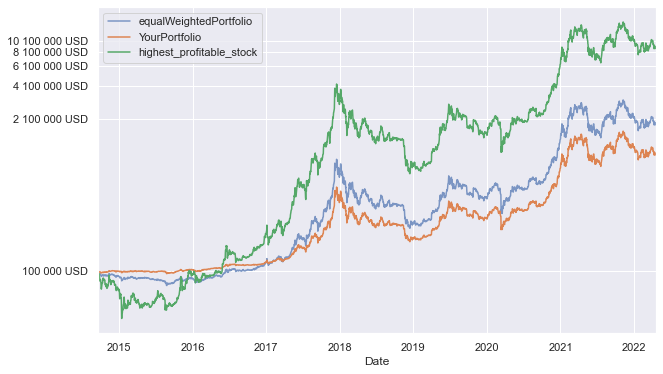

In [25]:
comparePortfolios_Plot(cum_returns);

In [26]:
proportions = calculate_proportions(cum_returns, df, weights)

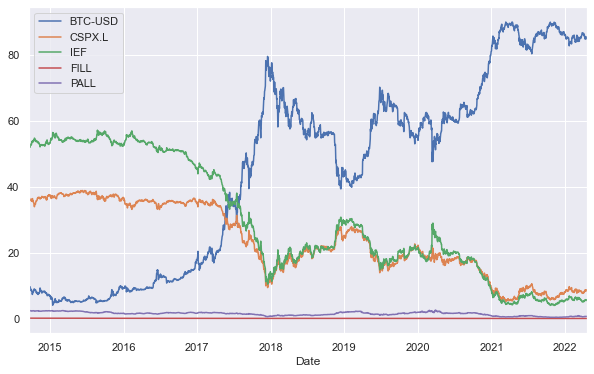

In [27]:
plot_proportions(proportions)

In [14]:
proportions

BTC-USD     CSPX.L        IEF      FILL      PALL
Date                                                           
2014-09-18   9.427716  36.303848  51.752210  0.098768  2.417459
2014-09-19   8.807043  36.541016  52.172814  0.099231  2.379896
2014-09-20   9.093144  36.426375  52.009132  0.098919  2.372430
2014-09-21   8.888851  36.508235  52.126011  0.099142  2.377762
2014-09-22   8.976767  36.255705  52.317100  0.098328  2.352101
...               ...        ...        ...       ...       ...
2022-04-16  85.194393   8.549242   5.622253  0.010773  0.623340
2022-04-17  84.970282   8.678651   5.707356  0.010936  0.632775
2022-04-18  85.314940   8.477095   5.558638  0.010781  0.638544
2022-04-19  85.532686   8.393348   5.445840  0.010597  0.617529
2022-04-20  85.404493   8.448281   5.497139  0.010686  0.639401

[2772 rows x 5 columns]

In [17]:
max_weights = weights*100*1.3

In [18]:
min_weights = weights*100*0.7

In [59]:
max_weights

array([13.13 , 46.657, 66.937,  0.13 ,  3.146])

In [60]:
min_weights

array([ 7.07 , 25.123, 36.043,  0.07 ,  1.694])

In [41]:
# Iterate by all rows in df
for i in range(len(proportions)):
    
    portfolio_value = cum_returns.iloc[:,:5]*buyAmt

    # copy old proportions. New will be overwrtited
    new_proportions = proportions
    
    # iterate by all columns (assets)
    for k in range(len(proportions.columns)):
        
        # If proportions are over the margin then: do rebalancing
        if new_proportions.iloc[i,k] < min_weights[k] or new_proportions.iloc[i,k] > max_weights[k]:
            
            # That is how portfolio balance look like in checking period
            check_day_prop = new_proportions.iloc[i,:].values

            # That is how we sould multiply our proportion to get proper one
            multiplier = weights*100/check_day_prop

            # It contains data year befor rebalancing date, which do not need to change anth
            previos_period = portfolio_value.iloc[:i]

            # It contains data after Rebalancing with new prop proportion
            next_period = portfolio_value.loc[portfolio_value.index[i] + relativedelta(days=1):]*multiplier

            # Portfolio value in time with new wages
            portfolio_value = pd.concat([previos_period, next_period])

            # We need to count proportion for each stock again
            proportions = pd.DataFrame(index=portfolio_value.index, columns=portfolio_value.columns.values)

            # Loop by new portfolio value and count new prop
            for i in range(len(portfolio_value.columns)):

                new_proportions.iloc[:,i] = portfolio_value.iloc[:,i]*100 / np.sum(portfolio_value, axis=1)
 
            # Break at the end here becouse we do rebalancing even if only one of the assets will go outside the permissible range
            break
                     
            
#             dates = proportions.index[i]
#             red_dates.append(dates)
#            print(f'Do the rebalance at {proportions.index[i]}')

        else:
            pass

In [29]:
cum_returns.iloc[:,:5]*buyAmt

BTC-USD        CSPX.L           IEF        FILL         PALL
Date                                                                          
2014-09-18    9373.551682  36095.276130  51454.884538   98.200496  2403.569839
2014-09-19    8718.878039  36175.215667  51650.529066   98.237237  2356.072110
2014-09-20    9030.446417  36175.215667  51650.529066   98.237237  2356.072110
2014-09-21    8807.768752  36175.215667  51650.529066   98.237237  2356.072110
2014-09-22    8881.332132  35870.260578  51760.903120   97.282410  2327.095405
...                   ...           ...           ...         ...          ...
2022-04-16  892755.139334  89587.819453  58915.792498  112.888787  6531.998456
2022-04-17  877129.654694  89587.819453  58915.792498  112.888787  6531.998456
2022-04-18  901627.161974  89587.819453  58744.921296  113.941137  6748.277630
2022-04-19  916568.112911  89943.104947  58357.617004  113.558464  6617.434838
2022-04-20  913733.099541  90387.214825  58813.270646  114.323811  6840.883661

[2772 rows x 5 columns]

In [30]:
portfolio_value

NameError: name 'portfolio_value' is not defined

In [22]:
proportions.iloc[i,:].values

array([ 6.91907123, 36.99114268, 53.69599829,  0.07921542,  2.31457237])

In [34]:
portfolio_value.loc[portfolio_value.index[i] + relativedelta(days=1):]

BTC-USD        CSPX.L           IEF        FILL         PALL
Date                                                                          
2014-12-19    7019.408277  37291.411587  53566.448817   81.512947  2333.069884
2014-12-20    7286.918155  37291.411587  53566.448817   81.512947  2333.069884
2014-12-21    7085.661822  37291.411587  53566.448817   81.512947  2333.069884
2014-12-22    7329.541107  37378.260223  53566.448817   80.771914  2351.889928
2014-12-23    7388.860218  37561.827205  53122.606068   81.772314  2354.578376
...                   ...           ...           ...         ...          ...
2022-04-16  892755.139334  89587.819453  58915.792498  112.888787  6531.998456
2022-04-17  877129.654694  89587.819453  58915.792498  112.888787  6531.998456
2022-04-18  901627.161974  89587.819453  58744.921296  113.941137  6748.277630
2022-04-19  916568.112911  89943.104947  58357.617004  113.558464  6617.434838
2022-04-20  913733.099541  90387.214825  58813.270646  114.323811  6840.883661

[2680 rows x 5 columns]

In [63]:
len(red_dates)

2676

In [33]:
portfolio_value.index[i] + relativedelta(days=1)

Timestamp('2014-12-19 00:00:00')

In [38]:
new_proportions

BTC-USD CSPX.L  IEF FILL PALL
Date                                    
2014-09-18     NaN    NaN  NaN  NaN  NaN
2014-09-19     NaN    NaN  NaN  NaN  NaN
2014-09-20     NaN    NaN  NaN  NaN  NaN
2014-09-21     NaN    NaN  NaN  NaN  NaN
2014-09-22     NaN    NaN  NaN  NaN  NaN
...            ...    ...  ...  ...  ...
2022-04-16     NaN    NaN  NaN  NaN  NaN
2022-04-17     NaN    NaN  NaN  NaN  NaN
2022-04-18     NaN    NaN  NaN  NaN  NaN
2022-04-19     NaN    NaN  NaN  NaN  NaN
2022-04-20     NaN    NaN  NaN  NaN  NaN

[2771 rows x 5 columns]

In [35]:
min_weights[0]

8.080000000000002

In [38]:
proportions.index[0]

Timestamp('2014-09-18 00:00:00')

In [45]:
proportions.iloc[2,0]

9.093143596947643

In [46]:
len(proportions.columns)

5

In [ ]:
def calculate_new_proportions(portfolio_value):
    
    # We need to count proportion for each stock again
    new_proportions = pd.DataFrame(index=portfolio_value.index, columns=portfolio_value.columns.values)

    # Loop by new portfolio value and count new prop
    for i in range(len(portfolio_value.columns)):

        new_proportions.iloc[:,i] = portfolio_value.iloc[:,i]*100 / np.sum(portfolio_value, axis=1)
        
    return new_proportions

In [ ]:
def calculate_new_portfolio_values_after_single_reb(portfolio_value, new_proportions, rebalancing_dates, weights, i):
    
    # That is how portfolio balance look like in chacking period
    check_day_prop = new_proportions.loc[[rebalancing_dates[i]]][new_proportions.columns].values 

    # That is how we sould multiply our proportion to get proper one
    multiplier = weights*100/check_day_prop

    # It contains data year befor rebalancing date, which do not need to change anth
    previos_period = portfolio_value.loc[:rebalancing_dates[i]]

    # It contains data after Rebalancing with new prop proportion
    next_period = portfolio_value.loc[rebalancing_dates[i] + relativedelta(days=1):]*multiplier

    # Portfolio value in time with new wages
    portfolio_value = pd.concat([previos_period, next_period])
    
    return portfolio_value

In [ ]:
def create_new_wallet_with_rebalanceing(rebalancing_dates, buyAmt, cum_returns, proportions):
    
    # This is the value of the portfolio from cumulated return multiplyed by buy Amount
    portfolio_value = cum_returns.iloc[:,:5]*buyAmt
    
    # copy old proportions. New will be overwrtited
    new_proportions = proportions
    
    
    # Loop throw rabalancing dates and make changes if necessery
    for i in range(len(rebalancing_dates)):
        
        # Function that calulates portfolio values over all period
        portfolio_value = calculate_new_portfolio_values_after_single_reb(portfolio_value, new_proportions, rebalancing_dates, weights, i)
        
        # Function that calculate new proportions base on new portfolio vales in period
        new_proportions = calculate_new_proportions(portfolio_value)
        
    return portfolio_value, new_proportions